In [20]:
IMG_HEIGHT=100
IMG_WIDTH=76

epsilon = 1
n_episodes = 1

#### Display related

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(observation, env_id, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(observation, cmap='gray')
    plt.title("%s | Step: %d %s" % (env_id, step, info))
    plt.axis('off')
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()

#### Preprocessing

In [6]:
import cv2
import numpy as np

def downsize(img_arry):
    return cv2.resize(img_arry, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_CUBIC)

def rgb2gray(img_arr):
    return np.dot(img_arr[...,:3], [0.299, 0.587, 0.114])

def normalize(img_arr):
    return np.divide(img_arr, 255.0)

def preprocess_image(img_arr):
    downsized = downsize(img_arr)
    gray = rgb2gray(downsized)
    return normalize(gray)
    

#### Memory

In [3]:
import random

class Memory:

    # wants the following input
    # [(state, action, reward, next_state, done)...]
    def __init__(self):
        self.memory = []

    # @params
    # state = previous 4 images
    # action = what action we took
    # reward = reward
    # next_state = what happened
    # done = done
    def add(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

#### Model

In [14]:
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten
from keras.layers import Dense, Input
from keras.models import Model
form keras.optimizers import RMSprop

def atari_model(n_actions):
    # Define the inputs
    ATARI_SHAPE = (4, IMG_HEIGHT, IMG_WIDTH)
    frames_input = Input(ATARI_SHAPE, name='frames')
    actions_input = Input((n_actions,), name='mask')
    
    # Convolution
    conv_1 = Convolution2D(16, 8, 8, subsample=(4, 4), activation='relu')(frames_input)
    conv_2 = Convolution2D(32, 4, 4, subsample=(2, 2), activation='relu')(conv_1)
    
    # Flatten
    conv_flattened = Flatten()(conv_2)
    
    # Hidden
    hidden = Dense(256, activation='relu')(conv_flattened)
    
    # Output
    output = Dense(n_actions)(hidden)
    
    # Multiply the output by the mask
    filtered_output = keras.layers.merge([output, actions_input], mode='mul')

    
    model = Model(input=[frames_input, actions_input], output=filtered_output)
    optimizer = RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
    model.compile(optimizer, loss='mse')
    
    return model

SyntaxError: invalid syntax (<ipython-input-14-2a2965404825>, line 5)

#### Main loop

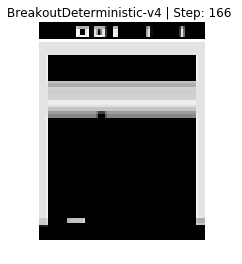

Finished after 167 timesteps


In [40]:
import gym
env = gym.make("BreakoutDeterministic-v4")

#model = atari_model(env.action_space.n)

for episode in range(n_episodes):
    state = env.reset()
    memory = Memory()

    for t in range(500):
        state = preprocess_image(env.render(mode='rgb_array'))
        show_state(state, env.spec.id, t)

        if random.random() < epsilon:
            action = env.action_space.sample() 
        else:
            # TODO: Select optimal actions
            action = env.action_space.sample()

        next_state_raw, reward, done, info = env.step(action)
        next_state = preprocess_image(next_state_raw)
        memory.add(state, action, reward, next_state, done)

        #batch = memory.sample(32)
        #fit_batch(model, batch)
        if done:
            print("Finished after {} timesteps".format(t+1))
            break;
    